In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from mtist import infer_mtist as im
from mtist import mtist_utils as mu
from mtist import graphing_utils as gu

from glob import glob

%config InlineBackend.figure_format='retina'

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams.update({"font.family": "Helvetica"})

rng = np.random.default_rng(11206)


In [19]:
meta = (
    pd.read_csv("../mtist1.0/mtist_datasets/mtist_metadata.csv")
    .drop(columns=["Unnamed: 0"])
    .set_index("did")
)

############################################################################################################
# FYI #
# MKSeqSpike was run non-sequentially on server, so need to make sure ES score csv was properly saved.
############################################################################################################

# Make sure that ES score has been calculated for MKSeqSpike

# fns = glob("mtist_datasets/mkseqspike_inference_result/*.csv")
# aijs, _ = mu.load_ground_truths(mu.GLOBALS.GT_DIR)

# raw_scores = {}

# for fn in fns:
#     # Complete the inference
#     did = int(fn.split(".csv")[0].split("aij_")[-1])
#     inferred_aij = np.loadtxt(fn, delimiter=",")

#     # Obtain gt used in the dataset
#     gt_used = meta.loc[did, "ground_truth"]
#     true_aij = aijs[gt_used]

#     # Calc ES score
#     es_score = im.calculate_es_score(true_aij, inferred_aij)

#     # Save the scores
#     raw_scores[did] = es_score

# df_es_scores = pd.DataFrame([raw_scores], index=["raw"]).T.sort_index()
# df_es_scores.to_csv(
#     "mtist_datasets/mkseqspike_inference_result/mkseqspike_es_scores.csv"
# )

In [20]:
###########################################################################################################
# Obtain normal ES Scores for 
############################################################################################################


methods = ["default", "ridge_CV", "lasso_CV", "elasticnet_CV", "mkseqspike"]
labels = ["L", "L2", "L1", "E", "MK"]

simple_methods = ["default", "ridge_CV", "lasso_CV", "elasticnet_CV"]

################################################################################

es = {
    method: pd.read_csv(
        f"../mtist1.0/mtist_datasets/{method}_inference_result/{method}_es_scores.csv"
    )["raw"]
    for method in methods
}

###########################################################################################################
# Calculate strong ES scores for 100 species
############################################################################################################

# Make sure that ES score has been calculated for MKSeqSpike

dids_100sp = meta.query("n_species == 100").index

gt_100sp = np.loadtxt(
    os.path.join("ground_truths", "interaction_coefficients", "100_sp_aij.csv"),
    delimiter=",",
)

strong_truth = gt_100sp.copy()
strong_truth[np.abs(strong_truth) < 0.25] = 0

cur_es_scores = {}
strong_es = {}
for method in methods:
    for did in dids_100sp:
        fn = f"../mtist1.0/mtist_datasets/{method}_inference_result/{method}_inferred_aij_{did}.csv"
        cur_aij = np.loadtxt(fn, delimiter=",")

        cur_es_scores[did] = im.calculate_es_score(strong_truth, cur_aij)

    strong_es[method] = pd.Series(cur_es_scores, name="raw")

In [21]:
expanded_nulls = {
    n_species: pd.read_csv(f"null_models/null_df_{n_species}sp.csv")
    .drop(columns=["Unnamed: 0"])[f"{n_species}-sp_null"]
    .values
    for n_species in [3, 10, 100]
}

expanded_nulls_strong = {
    n_species: pd.read_csv(f"null_models/null_df_{n_species}sp_strong.csv")
    .drop(columns=["Unnamed: 0"])[f"{n_species}-sp_null"]
    .values
    for n_species in [100]
}

display(expanded_nulls)
display(expanded_nulls_strong)

{3: array([0.33333333, 0.55555556, 0.66666667, ..., 0.66666667, 0.44444444,
        0.33333333]),
 10: array([0.51190476, 0.42857143, 0.55952381, ..., 0.44047619, 0.54761905,
        0.51190476]),
 100: array([0.51755652, 0.49446849, 0.46320346, ..., 0.49350649, 0.48100048,
        0.49254449])}

{100: array([0.51442308, 0.50480769, 0.5       , ..., 0.52884615, 0.59615385,
        0.51923077])}

In [22]:
expanded_nulls

{3: array([0.33333333, 0.55555556, 0.66666667, ..., 0.66666667, 0.44444444,
        0.33333333]),
 10: array([0.51190476, 0.42857143, 0.55952381, ..., 0.44047619, 0.54761905,
        0.51190476]),
 100: array([0.51755652, 0.49446849, 0.46320346, ..., 0.49350649, 0.48100048,
        0.49254449])}

In [23]:
data = pd.DataFrame(es)
data_strong = pd.DataFrame(strong_es)

display(data)
display(data_strong)

,default,ridge_CV,lasso_CV,elasticnet_CV,mkseqspike
0,0.533189,0.525012,0.519721,0.519962,0.528139
1,0.504089,0.543050,0.525974,0.523329,0.529101
2,0.496392,0.534873,0.506253,0.508658,0.497835
3,0.530544,0.540645,0.520924,0.529582,0.498797
4,0.524772,0.523329,0.518278,0.516354,0.521886
...,...,...,...,...,...
643,1.000000,1.000000,1.000000,1.000000,1.000000
644,0.888889,0.888889,0.888889,0.888889,0.777778
645,1.000000,1.000000,1.000000,1.000000,0.888889
646,1.000000,1.000000,1.000000,1.000000,1.000000


,default,ridge_CV,lasso_CV,elasticnet_CV,mkseqspike
0,0.789809,0.767516,0.716561,0.726115,0.748408
1,0.815287,0.847134,0.828025,0.824841,0.878981
2,0.726115,0.761146,0.633758,0.646497,0.659236
3,0.783439,0.834395,0.818471,0.828025,0.796178
4,0.732484,0.796178,0.751592,0.754777,0.783439
5,0.694268,0.840764,0.792994,0.799363,0.770701
6,0.745223,0.818471,0.773885,0.783439,0.751592
7,0.885350,0.878981,0.859873,0.856688,0.885350
8,0.579618,0.783439,0.764331,0.770701,0.732484
9,0.859873,0.898089,0.834395,0.840764,0.808917


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

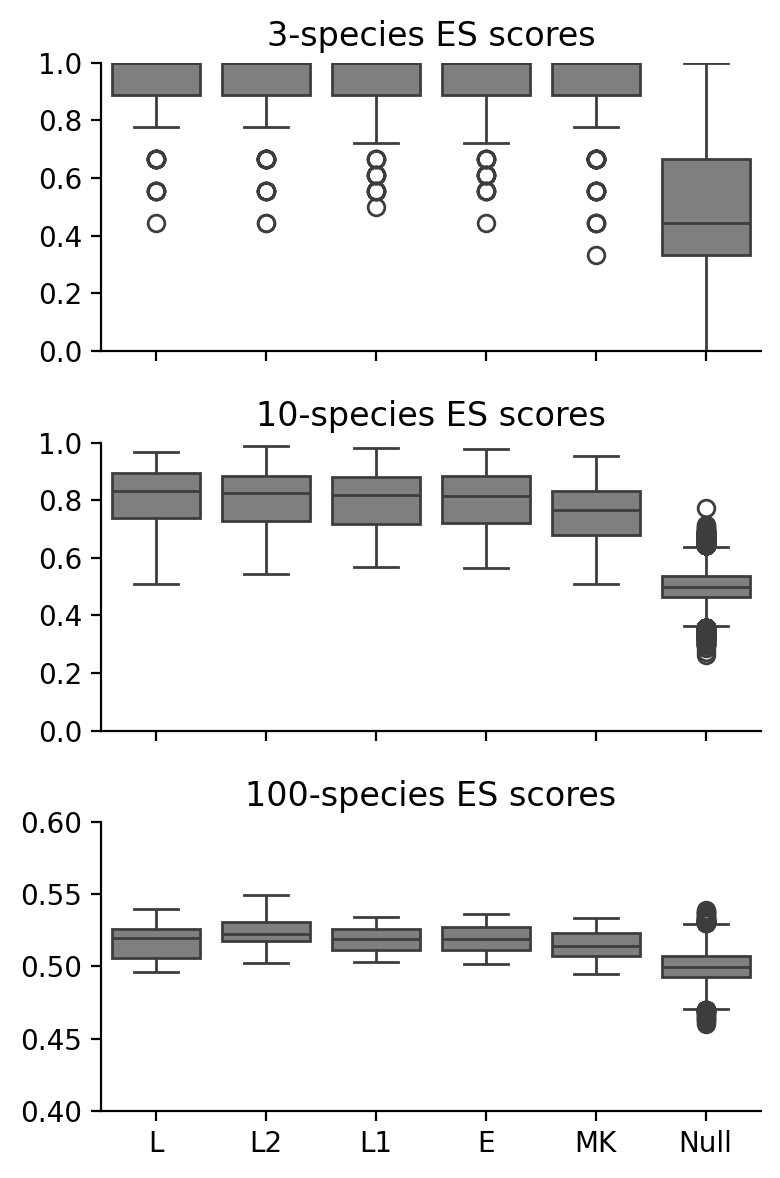

In [24]:
order = methods + ["null"]

fig, axes = gu.easy_subplots(nrows=3, base_figsize=(4, 2), sharex=True, sharey=False)

for n_species, ax in zip([3, 10, 100], axes):
    sns.boxplot(
        data=(
            pd.Series(expanded_nulls[n_species])
            .to_frame("null")
            .join(data.loc[meta.query("n_species == @n_species").index])[order]
        ),
        ax=ax,
        color="tab:gray",
    )

    ax.set_title(f"{n_species}-species ES scores")

plt.xticks(range(len(order)), labels + ["Null"])

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)
axes[2].set_ylim(0.44, 0.56)
axes[2].set_yticks(np.around(np.linspace(0.40, 0.60, 5), decimals=2))

sns.despine()
plt.tight_layout()

# gu.savefig(
#     fig,
#     os.path.join("exported_figures", "figure_4bc", "figure_4b"),
#     ft="svg",
# )

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

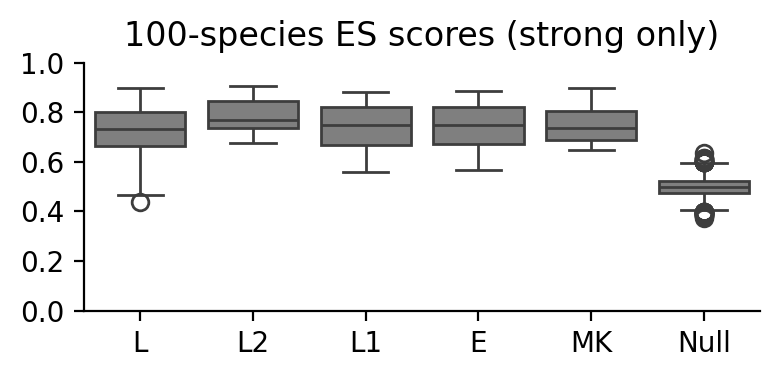

In [25]:
order = methods + ["null"]

fig, ax = gu.easy_subplots(nrows=1, base_figsize=(4, 2), sharex=True, sharey=False)

n_species = 100

sns.boxplot(
    data=(
        pd.Series(expanded_nulls_strong[n_species])
        .to_frame("null")
        .join(data_strong.loc[meta.query("n_species == @n_species").index])[order]
    ),
    ax=ax,
    color="tab:gray",
)

ax.set_title(f"{n_species}-species ES scores (strong only)")

plt.xticks(range(len(order)), labels + ["Null"])

ax.set_ylim(0, 1)
ax.set_yticks(np.around(np.linspace(0, 1, 6), decimals=2))

sns.despine()
plt.tight_layout()

# gu.savefig(
#     fig,
#     os.path.join("exported_figures", "figure_4bc", "figure_4c"),
#     ft="svg",
# )

#### Median Scores for 100-species

In [26]:
data.loc[meta.query("n_species == 100").index].median()

default          0.519481
ridge_CV         0.522246
lasso_CV         0.519000
elasticnet_CV    0.519120
mkseqspike       0.514190
dtype: float64

In [27]:
data_strong.median()

default          0.732484
ridge_CV         0.770701
lasso_CV         0.746815
elasticnet_CV    0.748408
mkseqspike       0.735669
dtype: float64